<a href="https://colab.research.google.com/github/aclarke500/police-data-analysis/blob/main/police_deaths_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [ ]:
from google.colab import drive
# drive.mount("/content/drive", force_remount=True)
drive.mount('/content/drive')

Mounted at /content/drive


In order to get the dataset to run this on your own machine, download it from [here](https://data.world/awram/us-police-involved-fatalities). Upload it as a csv to google sheets, or import locally on your own machine.

In [ ]:
import pandas as pd
file_id='1P2yE_jkzZEJDmvfpIbAQJWTCeUkV8EDF'
url = 'https://drive.google.com/uc?id={}'.format(file_id)
df = pd.read_csv(url, encoding='latin-1')
print(df.head())

   UID                     Name   Age  Gender   Race       Date         City  \
0  133            Karen O. Chin  44.0  Female  Asian   5/4/2000      Alameda   
1  169     Chyraphone Komvongsa  26.0    Male  Asian   6/2/2000       Fresno   
2  257            Ming Chinh Ly  36.0    Male  Asian  8/13/2000     Rosemead   
3  483            Kinh Quoc Dao  29.0    Male  Asian   2/9/2001  Valley Glen   
4  655  Vanpaseuth Phaisouphanh  25.0    Male  Asian  6/10/2001    Riverside   

  State Manner_of_death  Armed  Mental_illness   Flee  
0    CA            Shot    NaN           False  False  
1    CA            Shot    NaN           False  False  
2    CA            Shot    Gun           False  False  
3    CA            Shot    Gun           False  False  
4    CA            Shot  Knife           False  False  


# Comparison By Race

Grab all unique values from the race column, subset with that, get length and plot

Using data from [USA facts](https://usafacts.org/data/topics/people-society/population-and-demographics/our-changing-population/), we can get an estimation of the number of people in each racial group. These are some things that could lead to innacuracies or confounds:
* We are using a different data source then our original data set
* Instead of looking at a CSV and finding out the number of people for each year, we are looking at the census for 2010, which is smack dab in the middle of our datasets time frame

In [ ]:
race_proportions = { # sums to 100
    "Asian": 4.8,
    "Black" : 12.3,
    "Hispanic" : 16.4 ,
    "Other" : 1.8,
    "Native" : 0.9,
    "White" : 63.8,
}


In [ ]:
races = df['Race'].unique()
races = races[:-1] # remove nan
proportion_of_deaths = []
for race in races:
  count = len(df[df['Race'] == race])
  weighted_count = count/race_proportions[race]/100
  proportion_of_deaths.append(weighted_count)
  print(race, len(df[df['Race'] == race]))
prop_sum = sum(proportion_of_deaths)

Asian 173
Black 2536
Hispanic 1784
Other 48
Native 130
White 3855


## Fatalities by race

The number of deaths is now weighted with respect to population. However, we want to standardize and scale this, so lets scale it to 100%. Our sum for all of our weighted deaths is now 5.68. We need to solve 100 = x*5.68, so we're gonna import a library since its a new tool to learn and I can't be fucked into doing grade 9 math.  

In [ ]:
from sympy import symbols, Eq, solve
x = symbols('x')
equation = Eq(prop_sum * x, 100)
solution = solve(equation, x)[0]
print(solution)

17.1663409465242


Now let's multiple every value by that constant, so our graph adds up to 100.

In [ ]:
for i in range(len(proportion_of_deaths)):
  proportion_of_deaths[i] = proportion_of_deaths[i]*solution
print(proportion_of_deaths)

[106.208758829521, 607.574594426429, 320.557889330663, 78.5822030646170, 425.653599933342, 178.057049067848]


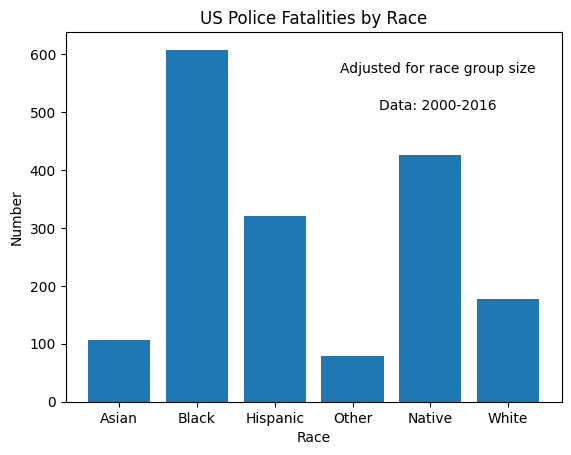

In [ ]:
import matplotlib.pyplot as plt
plt.bar(races, proportion_of_deaths)
plt.xlabel('Race')
plt.ylabel('Number')
plt.title('US Police Fatalities by Race')
plt.text(0.75, 0.9, 'Adjusted for race group size', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.75, 0.8, 'Data: 2000-2016', ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

Now lets make a dictionary with these proportional values to make comparisons against different races.

In [ ]:
race_death_dict = {}
for race, count in zip(races, proportion_of_deaths):
  race_death_dict[race] = count
for race in race_death_dict.keys():
  print(race, ":", race_death_dict[race] )

Asian : 106.208758829521
Black : 607.574594426429
Hispanic : 320.557889330663
Other : 78.5822030646170
Native : 425.653599933342
White : 178.057049067848


Let's compare the data to answer the question we're all thinking about:

In [ ]:
black_times_likely = race_death_dict['Black']/race_death_dict['White']
print(black_times_likely)

3.41224679172862


## Unarmed deaths by race

One of the ways we can try to inquire about police brutality, systemic racism, and other factors, is to look at 'unjustified' or 'unnecessary' shootings. I am not a police officer, and I will not pretend to understand the horror and stress going through anyones mind when they feel they have to pull the trigger. Just because someone is unarmed doesn't mean the officer knew they did not pose a threat in that instance. However, I will use unarmed deaths to predict this. We are now going to compare armed killings vs unarmed killings to see if there is a difference between races.

Race: Asian 	 Armed:  89 	 Unarmed: 1 	 Percent unarmed: 1.11
Race: Black 	 Armed:  1274 	 Unarmed: 132 	 Percent unarmed: 9.39
Race: Hispanic 	 Armed:  871 	 Unarmed: 67 	 Percent unarmed: 7.14
Race: Other 	 Armed:  20 	 Unarmed: 1 	 Percent unarmed: 4.76
Race: Native 	 Armed:  68 	 Unarmed: 4 	 Percent unarmed: 5.56
Race: White 	 Armed:  2176 	 Unarmed: 110 	 Percent unarmed: 4.81


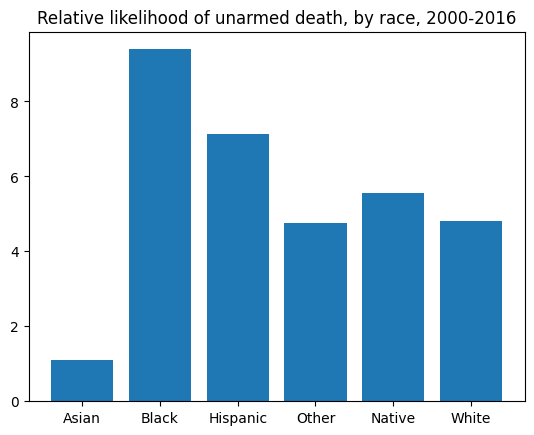

In [ ]:
# seperate armed and unarmed
armed_df = df[df['Armed'].notnull()]
total_num_not_armed=armed_df[armed_df['Armed'] == 'Unarmed']
total_num_armed=armed_df[armed_df['Armed'] != 'Unarmed']

import math
pct_of_unarmed_death = []
for race in races:
  # get lengths
  race_armed = len(total_num_armed[total_num_armed['Race'] == race])
  race_unarmed = len(total_num_not_armed[total_num_not_armed['Race'] == race])
  # format and standardize
  pct= round(race_unarmed/(race_armed+race_unarmed)*100,2) # prob = what you want / total, * 100 to standardize
  pct_of_unarmed_death.append(pct)
  print(f"Race: {race} \t Armed:  {(race_armed)} \t Unarmed: {(race_unarmed)} \t Percent unarmed: {pct}")
plt.clf()
plt.bar(races, pct_of_unarmed_death)
plt.title("Relative likelihood of unarmed death, by race, 2000-2016")
plt.show()


Now, to compare black deaths against the average. We will multiply the percent unarmed by the percent in the population dictionary for each respective race, then divide that by the total to get the average. We can then compare that to other races to see how they compare to the average.

In [75]:
relative_risk_unarmed_death = {}
for i in range(len(races)):
  relative_risk_unarmed_death[races[i]] = pct_of_unarmed_death[i]*race_proportions[races[i]]

vals=relative_risk_unarmed_death.values()
total=0
for n in vals:
  total+=n
weighted_not_standardized_portion=[]
for key in relative_risk_unarmed_death.keys():
  x=round(100*relative_risk_unarmed_death[key]/(race_proportions[key]),2)
  weighted_not_standardized_portion.append(x)
  print(f"{key}:     \tTotal: {round(relative_risk_unarmed_death[key],2)}\t Average: {x}")



Asian:     	Total: 5.33	 Average: 111.0
Black:     	Total: 115.5	 Average: 939.0
Hispanic:     	Total: 117.1	 Average: 714.0
Other:     	Total: 8.57	 Average: 476.0
Native:     	Total: 5.0	 Average: 556.0
White:     	Total: 306.88	 Average: 481.0
3277.0


In [79]:
total_k=sum(weighted_not_standardized_portion)
k = symbols('k')
equation = Eq(total_k * k, 100)
solution = solve(equation, k)[0]
print(solution)
standardized_portion_unarmed_kills = {}
total=0
for i in range(len(weighted_not_standardized_portion)):
  standardized_portion_unarmed_kills[races[i]]=weighted_not_standardized_portion[i]*solution

print(total)
for key in standardized_portion_unarmed_kills.keys():
  print(f"{key}:    \t: {standardized_portion_unarmed_kills[key]}")

0.0305157155935307
0
Asian:    	: 3.38724443088190
Black:    	: 28.6542569423253
Hispanic:    	: 21.7882209337809
Other:    	: 14.5254806225206
Native:    	: 16.9667378700031
White:    	: 14.6780592004883


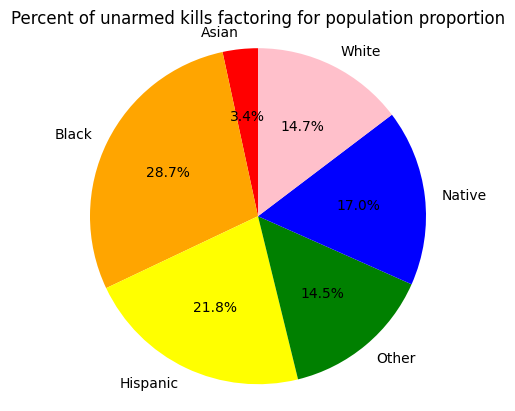

16.67


In [83]:
# import matplotlib.pyplot as plt

# Data for the pie chart
labels = standardized_portion_unarmed_kills.keys()
sizes = standardized_portion_unarmed_kills.values()
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'pink']
# explode = [0.1, 0, 0, 0]  # To highlight a slice, set the corresponding explode value > 0
plt.clf()
# Create the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Percent of unarmed kills factoring for population proportion')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Display the pie chart
plt.show()
print(round(100/6,2))


# Comparison by Gender

In order to compare against men and women, let's get the count for each and store it in a dictionary.

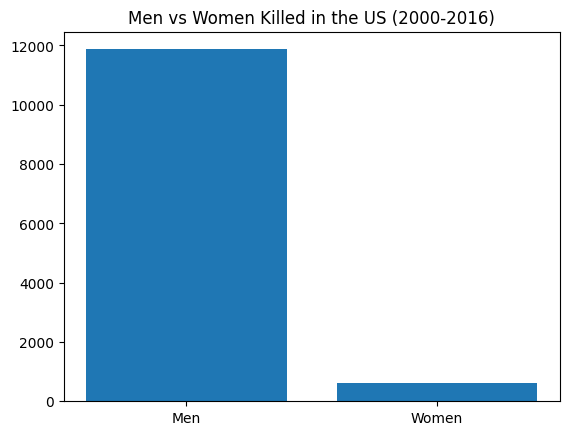

0.95089321477209


In [54]:
men_killed = len(df[df['Gender'] == 'Male'])
women_killed = len(df[df['Gender'] == 'Female'])
plt.clf() # clear previous figure (race)
plt.bar(['Men', 'Women'], [men_killed, women_killed])
plt.title('Men vs Women Killed in the US (2000-2016)')
plt.show()
print(men_killed/(men_killed+women_killed))